In [1]:
import torch
from binNF.normalizing_flows.manager import *
import matplotlib.pyplot as plt
import numpy as np


In [2]:
def step(x):
    a=torch.zeros_like(x[:,0])
    b=torch.ones_like(x[:,0])
   
    return torch.where(abs(x[:,0])>0.5,a,b)

def gaussian(x):
    return torch.exp( -torch.sum((x)**2,-1))

def gaussianb(x):
    return torch.exp( -(x)**2)[:,0]

def gaussianbnp(x):
    return np.exp( -(x)**2 )[:,0]

def gaussiannp(x):
    return np.exp( -(x[:,0])**2 )

def con(x):
    y=torch.empty(x.shape[0])
    return y.fill_(5)

def sin(x):
    return 2+torch.sin(x[:,1])

def lin(x):
    return 0.2*x[:,0]+0.5

def sinnp(x):
    return 2+np.sin(x[:,1])

def tanp(r):
    return (1+((torch.tan((r-0.5)*np.pi))**2))*np.pi

In [3]:
n_flow = 2      # number of dimensions


# We define our NormalizingFlow object 
NF =  AffineManager(n_flow=n_flow)



In [29]:
#The model is created
NF.create_model(n_pass_through=1,n_cells=1, NN=[200,200,200,200], roll_step=1)
optim = torch.optim.SGD(NF._model.parameters(),lr=2e-7, weight_decay=1e-7) 


In [30]:

history = NF._train_variance_forward(gaussian,epochs=60,batch_size=20000,optimizer_object=optim, logdir="./logs/tmp/")


2.4372817403629093e-14


/home/niklas/miniconda3/envs/cs231n/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


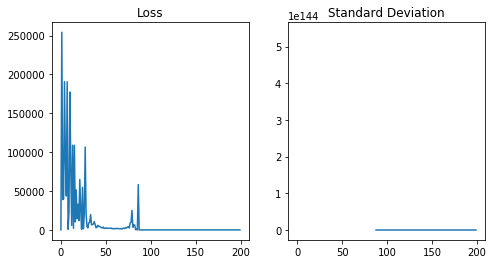

In [18]:

losses=[]
for key, value in history.items():
    losses.append(value["loss"])

fig = plt.figure(figsize=(12, 4))
a1=fig.add_subplot(131)
plt.plot(losses)
print(min(losses))
a1.title.set_text('Loss')
a2=fig.add_subplot(132)
plt.plot(np.sqrt(np.exp(losses)))
a2.title.set_text('Standard Deviation')






In [31]:
w = torch.empty(10, NF.n_flow)
torch.nn.init.uniform_(w,0,1)

print("W")
print(w)
                    #print(self.format_input(w).requires_grad)
print("with jacob")                  # Output a sample of (phase-space point, forward Jacobian)
print(NF.format_input(w))

print("mapped")
print(NF.format_input(100*torch.tan((w-0.5)*(np.pi))))
XJ=NF.model(NF.format_input(100*torch.tan((w-0.5)*(np.pi))))


                    # Separate the points and their Jacobians:
print("XJ")
print(XJ)# This sample is fixed, we optimize the Jacobian
K = ((XJ[:, :-1]).detach())
X=torch.atan(K/100)/np.pi+0.5
#X=torch.tan((X-0.5)*(np.pi))
print("X")
print(X)
#print("diff")
#print(X[:,0]-w[:,1])

f=gaussian
print("f(x)")
print(f(X))


print("fXJ")
print(torch.mul(f(X), XJ[:, -1]))

print("loss without jac")
print(torch.mean(f(X)**2))

print("squared mean")
print(torch.mean(f(X))**2)

print("loss")
print(torch.mean(torch.mul(f(X), XJ[:, -1])**2))



W
tensor([[0.9961, 0.1509],
        [0.4255, 0.1503],
        [0.1513, 0.1617],
        [0.6122, 0.4908],
        [0.6845, 0.4312],
        [0.9201, 0.6762],
        [0.8221, 0.7553],
        [0.1409, 0.7475],
        [0.4087, 0.1368],
        [0.5259, 0.2732]])
with jacob
tensor([[0.9961, 0.1509, 1.0000],
        [0.4255, 0.1503, 1.0000],
        [0.1513, 0.1617, 1.0000],
        [0.6122, 0.4908, 1.0000],
        [0.6845, 0.4312, 1.0000],
        [0.9201, 0.6762, 1.0000],
        [0.8221, 0.7553, 1.0000],
        [0.1409, 0.7475, 1.0000],
        [0.4087, 0.1368, 1.0000],
        [0.5259, 0.2732, 1.0000]])
mapped
tensor([[ 8.2424e+03, -1.9489e+02,  1.0000e+00],
        [-2.3842e+01, -1.9575e+02,  1.0000e+00],
        [-1.9433e+02, -1.7958e+02,  1.0000e+00],
        [ 3.6784e+01, -2.8922e+00,  1.0000e+00],
        [ 6.5480e+01, -2.1948e+01,  1.0000e+00],
        [ 3.8988e+02,  6.1795e+01,  1.0000e+00],
        [ 1.5994e+02,  1.0337e+02,  1.0000e+00],
        [-2.1098e+02,  9.8423e+01, 

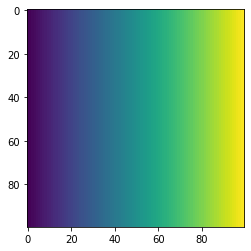

In [33]:
xs = np.linspace(0,1,100)
ys = np.linspace(1,0,100) # in images the y axis is inverted
Xs,Ys = np.meshgrid(xs,ys)
zs=lin(np.array(list(zip(Xs.reshape(100*100),Ys.reshape(100*100)))).astype(np.float32)).reshape(100,100)
plt.imshow(zs)
plt.show()

In [54]:
print("reset")
NF.create_model(n_pass_through=1,n_cells=1, nn_width=2, NN=[20,20,20], roll_step=1)

w = torch.empty(10000, NF.n_flow, requires_grad=True)
torch.nn.init.uniform_(w,0,1)

print("W")
print(w)
                    #print(self.format_input(w).requires_grad)
print("with jacob")                  # Output a sample of (phase-space point, forward Jacobian)
print(NF.format_input(w))
XJ = NF.model(NF.format_input(w))

                    # Separate the points and their Jacobians:
print("XJ")
print(XJ)# This sample is fixed, we optimize the Jacobian
X = ((XJ[:, :-1]).detach())
print("X")
print(X)
print("diff")
print(X[:,0]-w[:,1])
print("f(x)")
print(sin(X))

print("fXJ")
print(torch.mul(sin(X), XJ[:, -1]))

reset
W
tensor([[0.9335, 0.9622],
        [0.5436, 0.2371],
        [0.5855, 0.5038],
        ...,
        [0.8563, 0.5714],
        [0.7551, 0.0883],
        [0.6047, 0.2965]], requires_grad=True)
with jacob
tensor([[0.9335, 0.9622, 1.0000],
        [0.5436, 0.2371, 1.0000],
        [0.5855, 0.5038, 1.0000],
        ...,
        [0.8563, 0.5714, 1.0000],
        [0.7551, 0.0883, 1.0000],
        [0.6047, 0.2965, 1.0000]], grad_fn=<CatBackward>)
XJ
tensor([[ 0.9335, -0.0543, -0.0564],
        [ 0.5436, -0.0130, -0.0550],
        [ 0.5855, -0.0278, -0.0552],
        ...,
        [ 0.8563, -0.0322, -0.0564],
        [ 0.7551, -0.0050, -0.0564],
        [ 0.6047, -0.0164, -0.0554]], grad_fn=<CatBackward>)
X
tensor([[ 0.9335, -0.0543],
        [ 0.5436, -0.0130],
        [ 0.5855, -0.0278],
        ...,
        [ 0.8563, -0.0322],
        [ 0.7551, -0.0050],
        [ 0.6047, -0.0164]])
diff
tensor([-0.0288,  0.3066,  0.0817,  ...,  0.2848,  0.6668,  0.3081],
       grad_fn=<SubBackward0>)

In [ ]:
"""
#a4=fig.add_subplot(143)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(X[:,0],X[:,1],X[:,2])
#plt.2d(X[:,0],X[:,1],X[:,2])
#ax.set_aspect(aspect=1.)
ax.title.set_text('Jacobian after training')
ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    left=True,         # ticks along the top edge are off
    labelbottom=True,
    labelleft=True)


NF.create_model(n_pass_through=1,n_cells=1, nn_width=2, NN=[5], roll_step=1)
rcParams['axes.labelpad'] = 800
z = torch.empty((10000,2)) 
torch.nn.init.uniform_(z,0,1)

w=NF.format_input(z)
X=NF.model(w).data.numpy()
fig = plt.figure()
ax1 = fig.add_subplot(211, projection='3d')
ax1.scatter3D(X[:,0],X[:,1],X[:,2])
#plt.2d(X[:,0],X[:,1],X[:,2])
#ax.set_aspect(aspect=1.)
ax1.title.set_text('Jacobian before training')
ax1.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    left=True,         # ticks along the top edge are off
    labelbottom=True,
    labelleft=True)
#ax1.auto_scale_xyz([0.5, 2], [0, 1], [1.55, 1.75])
ax1.xaxis._axinfo['label']['space_factor'] = 4.8
ax1.zaxis._axinfo['label']['space_factor'] = 8.8
rcParams['axes.labelpad'] = 80

print("\n")
"""

In [67]:
w = torch.empty(2000000, 1)
torch.nn.init.uniform_(w)
print(torch.mean(w))
Y=torch.tan((w-0.5)*(np.pi))
print(torch.mean(torch.mul(Y,1/(np.pi*(w**2)+np.pi))))


tensor(0.4999)
tensor(-0.7164)


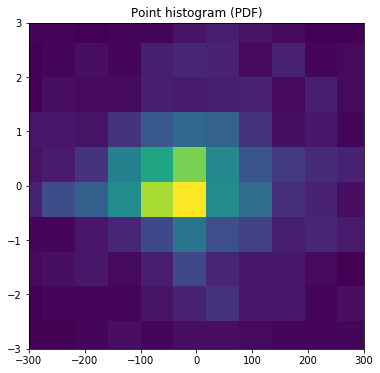

In [45]:
w = torch.empty((1600,2)) 
torch.nn.init.uniform_(w,0,1)
z=100*torch.tan((w-0.5)*(np.pi))
Y=NF.format_input(z)
X=NF.model(Y)
Z=(torch.atan(X)/np.pi+0.5).data.numpy()
#print(Z)
X=X.data.numpy()
z=z.data.numpy()
#a3=fig.add_subplot(133)
fig = plt.figure(figsize=(6, 6))
a3=fig.add_subplot(111)
plt.hist2d(X[:,0],X[:,1],bins=2500)
axes = plt.gca()
axes.set_xlim([-300,300])
axes.set_ylim([-3,3])
#a3.set_aspect(aspect=1.)


a3.title.set_text('Point histogram (PDF)')
a3.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    left=True,         # ticks along the top edge are off
    labelbottom=True,
    labelleft=True)
